# 1. Introduction
The dataset used in this project includes data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. The data contains 17 attributes and 2111 records, the records are labeled with the class variable NObesity (Obesity Level), that allows classification of the data using the values of Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III.

The data and complete information about the variables is available in: https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

The objective of this notebook is to show how to develop a model to predict obesity. The first model predicts presence or absence of obesity, which includes every level after Normal Weight, and the second model predicts the specific level.

# 2. Import required libraries
Import necessary libraries such as pandas, matplotlib, seaborn, and scipy for running the code.

In [ ]:
import pandas as pd
import plotnine as pn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, GridSearchCV, validation_curve
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier
)

%matplotlib inline

# 3. Data pre-processing
Load and pre-process the dataset.

In [35]:
# https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

# Load the dataset
data = 'Data/RawData.csv'

# Read the dataset
data = pd.read_csv(data)
data.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [36]:
# Identify missing values
data.isnull().sum()
print(data.isnull().sum())

# Shape of the dataset
data.shape
print(data.shape)

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
(2111, 17)


In [37]:
# Transform all the categorical x variables into numerical variables

# Transform 'Gender' column to numerical values, Female 0 and Male 1
data['Gender'] = data['Gender'].map({'Female': 0, 'Male': 1})
# Check the transformation
print(data['Gender'].head())

# Transform binary columns to numerical values (yes = 1, no = 0)
columns_to_transform = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
for column in columns_to_transform:
    data[column] = data[column].map({'yes': 1, 'no': 0})
# Check the transformation
print(data[columns_to_transform].head())


# Transform 'CAEC' column to numerical values
data['CAEC'] = data['CAEC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})
# Check the transformation
print(data['CAEC'].head())
# Transform 'CALC' column to numerical values
data['CALC'] = data['CALC'].map({'Always': 3, 'Frequently': 2, 'Sometimes': 1, 'no': 0})
# Check the transformation
print(data['CALC'].head())
# Transform 'MTRANS' column to numerical values
data['MTRANS'] = data['MTRANS'].map({'Public_Transportation': 1, 'Walking' : 2, 'Automobile': 3, 'Motorbike': 4, 'Bike': 5})
# Check the transformation
print(data['MTRANS'].head())



0    0
1    0
2    1
3    1
4    1
Name: Gender, dtype: int64
   family_history_with_overweight  FAVC  SMOKE  SCC
0                               1     0      0    0
1                               1     0      1    1
2                               1     0      0    0
3                               0     0      0    0
4                               0     0      0    0
0    1
1    1
2    1
3    1
4    1
Name: CAEC, dtype: int64
0    0
1    1
2    2
3    2
4    1
Name: CALC, dtype: int64
0    1
1    1
2    1
3    2
4    1
Name: MTRANS, dtype: int64


In [38]:
# Transform 'NObeyesdad' column to numerical values Overweight = 1, No_Overweight = 0
data['Overweight'] = data['NObeyesdad'].map({
    'Insufficient_Weight': 0,
    'Normal_Weight': 0,
    'Overweight_Level_I': 1,
    'Overweight_Level_II': 1,
    'Obesity_Type_I': 1,
    'Obesity_Type_II': 1,
    'Obesity_Type_III': 1
})

# Check the transformation
print(data[['NObeyesdad', 'Overweight']].head())

            NObeyesdad  Overweight
0        Normal_Weight           0
1        Normal_Weight           0
2        Normal_Weight           0
3   Overweight_Level_I           1
4  Overweight_Level_II           1


In [39]:
# Statistical description of the DataFrame
data.describe()
print(data.describe())

            Gender          Age       Height       Weight  \
count  2111.000000  2111.000000  2111.000000  2111.000000   
mean      0.505921    24.312600     1.701677    86.586058   
std       0.500083     6.345968     0.093305    26.191172   
min       0.000000    14.000000     1.450000    39.000000   
25%       0.000000    19.947192     1.630000    65.473343   
50%       1.000000    22.777890     1.700499    83.000000   
75%       1.000000    26.000000     1.768464   107.430682   
max       1.000000    61.000000     1.980000   173.000000   

       family_history_with_overweight         FAVC         FCVC          NCP  \
count                     2111.000000  2111.000000  2111.000000  2111.000000   
mean                         0.817622     0.883941     2.419043     2.685628   
std                          0.386247     0.320371     0.533927     0.778039   
min                          0.000000     0.000000     1.000000     1.000000   
25%                          1.000000     1.000000

# 4.1 Model setup 1
Set up a model to predict whether a person is overweight or not. 

In [40]:
# 1) Prepare train/test sets
y = data.Overweight
X = data.drop(columns=['Overweight', 'NObeyesdad'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=0,
    stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


In [41]:
# 2) Define base models
models = {
    "RandomForest": RandomForestClassifier(random_state=0),
    "AdaBoost":    AdaBoostClassifier(random_state=0),
    "GBM":         GradientBoostingClassifier(random_state=0),
    "HistGBM":     HistGradientBoostingClassifier(random_state=0),
    "XGBoost":     XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0),
}


In [42]:
# 3) Define hyperparameter grids
param_grids = {
    "RandomForest": {
        "n_estimators": [100, 200, 500],
        "max_depth":    [None, 5, 10],
        "min_samples_split": [2, 5, 10]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate":[0.5, 1.0, 1.5]
    },
    "GBM": {
        "n_estimators":   [100, 200, 500],
        "learning_rate":  [0.01, 0.05, 0.1],
        "max_depth":      [3, 5, 7]
    },
    "HistGBM": {
        "max_iter":       [100, 200],
        "learning_rate":  [0.01, 0.05, 0.1],
        "max_depth":      [None, 5, 10]
    },
    "XGBoost": {
         "n_estimators": [100, 200, 500],
         "learning_rate": [0.01, 0.05, 0.1],
         "max_depth":     [3, 5, 7]
     }
}


# 4.2 Hyperparameter tuning


In [ ]:
# 4) Hyperparameter tuning
tuned_models = {}
for name, base_clf in models.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(
        estimator=base_clf,
        param_grid=param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    print(f" → Best params for {name}: {grid.best_params_}")
    print(f" → Best CV acc:         {grid.best_score_:.4f}\n")
    tuned_models[name] = grid.best_estimator_

In [ ]:
# 5) Build a soft-voting ensemble from your top 4 tuned models (including XGBoost)
tuned_models["Voting"] = VotingClassifier(
    estimators=[
        ('rf',   tuned_models["RandomForest"]),
        ('gbm',  tuned_models["GBM"]),
        ('ada',  tuned_models["AdaBoost"]),
        ('xgb',  tuned_models["XGBoost"])
    ],
    voting='soft'
)

In [ ]:
# 6) Cross-validate all tuned models
cv_summary = []
for name, clf in tuned_models.items():
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_summary.append({
        'model': name,
        'mean_cv_acc': np.mean(scores),
        'std_cv_acc':  np.std(scores)
    })

cv_df = pd.DataFrame(cv_summary).sort_values('mean_cv_acc', ascending=False)
print("CV results for tuned models:\n", cv_df)

# 4.3 Results


### Test the model after hyperparameter tuning

In [ ]:
# 7) Final evaluation: train best model on full training set & test
best_name = cv_df.iloc[0]['model']
best_clf  = tuned_models[best_name]
print(f"\nTraining best model ({best_name}) on full training set...")
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)
print(f"\n=== {best_name} on TEST SET ===")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

### Use the model to make a prediction of overweight / not overweight.

In [ ]:
# Create a dataset with data that matches the model's expected features
data_subject1 = pd.DataFrame({
    'Gender': [0],  # 1 for Male, 0 for Female
    'Age': [37],  # Age in years
    'Height': [1.73],  # Height in meters
    'Weight': [121.3],  # Weight in kilograms
    'family_history_with_overweight': [1],  # 1 for yes, 0 for no
    'FAVC': [1],  # Eat high caloric food: 1 for yes, 0 for no
    'FCVC': [1],  # Frequency for vegetables consumption: Never = 1, Sometimes = 2, Always = 3    
    'NCP': [3],  # Daily number of meals: Between 1-2 = 1, Three = 2, More than three = 3
    'CAEC': [1],  # Frequency for eating between meals: No = 0, Sometimes = 1, Frequently = 2, Always = 3
    'SMOKE': [1],  # 1 for yes, 0 for no
    'CH2O': [2],  # Water consumption: < 1 Liter = 1, 1-2 Liters = 2, > 2 Liters = 3
    'SCC': [0],  # Monitor calories: 1 for yes, 0 for no
    'FAF': [0],  # Frequency for physical activity: Do not do any = 0, 1-2 times/week = 1, 3-4 times/week = 2, > 4 times/week = 3
    'TUE': [2],  # Time spent on technological devices: < 2 hours = 0, 2-5 hours = 1, > 5 hours = 2
    'CALC': [0],  # Frequency for alcohol consumption: Do not drink = 0, Sometimes = 1, Frequently = 2, Always = 3
    'MTRANS': [1]  # Transportation mode: Public_Transportation = 1, Walking = 2, Automobile = 3, Motorbike = 4, Bike = 5
})

# Ensure the data is scaled using the same scaler as the training data
data_subject1 = scaler.transform(data_subject1)

# Predict using the trained model
prediction = best_model.predict(data_subject1)

# Map the prediction to the corresponding weight level
overweight = {
    0: 'Not overweight',
    1: 'Overweight',

# Display the prediction
predicted_overweight = overweight.get(prediction[0], "Unknown Level")
print(f"Prediction for subject 1: {prediction}")


}

# 5.1 Model setup 2
Set up a model to predict the level of weight of a person.

In [43]:
# Transform 'NObeyesdad' column to numerical values and create a new column 'WeightLevel'
data['WeightLevel'] = data['NObeyesdad'].map({
    'Insufficient_Weight': 1,
    'Normal_Weight': 2,
    'Overweight_Level_I': 3,
    'Overweight_Level_II': 4,
    'Obesity_Type_I': 5,
    'Obesity_Type_II': 6,
    'Obesity_Type_III': 7
})

# Check the transformation
print(data[['NObeyesdad', 'WeightLevel']].head())

            NObeyesdad  WeightLevel
0        Normal_Weight            2
1        Normal_Weight            2
2        Normal_Weight            2
3   Overweight_Level_I            3
4  Overweight_Level_II            4


In [44]:
# Setup train/test data
# Get the y values and drop from df
y = data.WeightLevel
X = data.drop(columns=['WeightLevel', 'Overweight', 'NObeyesdad'])

# Split to 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Scale the data in x_train and x_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
# Setup train/test data

# Get the y values and drop from df
y= data.WeightLevel
# Drop the y column from the DataFrame
X= data.drop(columns=['WeightLevel', 'Overweight', 'NObeyesdad'])

# Split to 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Scale the data in x_train and x_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
# Define the base model
lda = LinearDiscriminantAnalysis()

# 5.2 Hyperparameter tuning


In [47]:
# Define the hyperparameters to tune
param_grid = [
    {'solver': ['svd']},  # 'svd' does not support shrinkage
    {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.1, 0.5, 0.9]}  # Shrinkage is valid for 'lsqr' and 'eigen'
]

# Configure GridSearchCV
grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")

# Use the best model found
best_lda = grid_search.best_estimator_

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best hyperparameters: {'solver': 'svd'}
Best accuracy: 0.8894621251447511


# 5.3 Results


In [48]:
# Get model.score for both training and test data for Fisher's Discriminant Analysis
print(f'Model score on training data: {best_lda.score(X_train, y_train)}')
print(f'Model score on testing data: {best_lda.score(X_test, y_test)}')

Model score on training data: 0.899557801642451
Model score on testing data: 0.8920454545454546


Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.95      0.92        78
           2       0.81      0.67      0.73        69
           3       0.74      0.79      0.77        68
           4       0.79      0.86      0.83        66
           5       0.99      0.92      0.95        86
           6       0.97      1.00      0.99        73
           7       1.00      1.00      1.00        88

    accuracy                           0.89       528
   macro avg       0.88      0.88      0.88       528
weighted avg       0.89      0.89      0.89       528



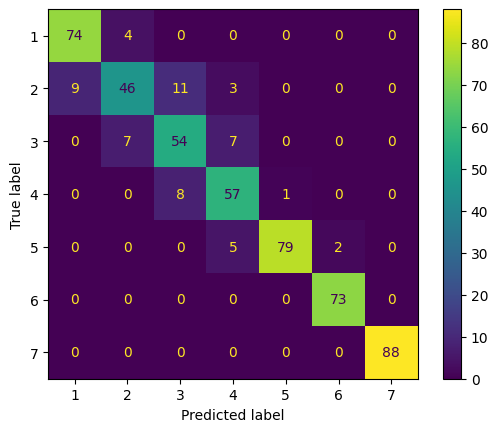

In [49]:
# Make predictions
y_pred = best_lda.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_lda.classes_).plot()
plt.show()

# 5.4 Repeat with SVM

In [52]:

# 1. Prepare the data
# Split the data into features (X) and target labels (y)
y = data['WeightLevel']  # Target variable
X = data.drop(columns=['WeightLevel', 'Overweight', 'NObeyesdad'])  # Features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 2. Define the SVM model
svm = SVC(probability=True, random_state=0)

# 3. Perform hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto']  # Kernel coefficient
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model found
best_svm = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


In [53]:
# Get model.score for both training and test data for Support Vector Machines (SVM)
print(f'Model score on training data: {best_svm.score(X_train, y_train)}')
print(f'Model score on testing data: {best_svm.score(X_test, y_test)}')

Model score on training data: 0.9804169298799748
Model score on testing data: 0.9678030303030303


Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.99        68
           2       1.00      0.96      0.98        72
           3       0.92      0.95      0.93        73
           4       0.91      0.93      0.92        72
           5       1.00      0.97      0.98        88
           6       0.97      1.00      0.99        74
           7       1.00      0.98      0.99        81

    accuracy                           0.97       528
   macro avg       0.97      0.97      0.97       528
weighted avg       0.97      0.97      0.97       528



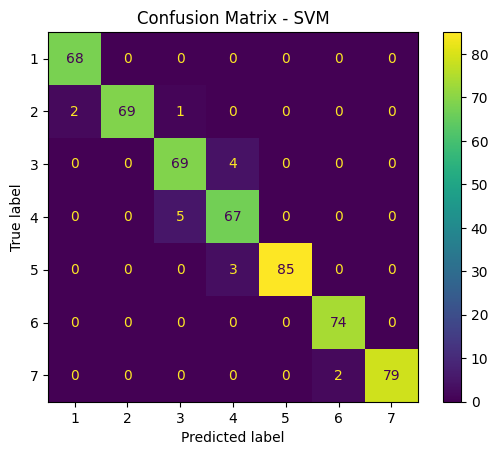

In [54]:
# 4. Evaluate the model on the test set
y_pred = best_svm.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_).plot(cmap='viridis')
plt.title("Confusion Matrix - SVM")
plt.show()

### Use the SVM model to make a prediction of weight level.

In [57]:
# Create a dataset with data that matches the model's expected features
data_subject2 = pd.DataFrame({
    'Gender': [0],  # 1 for Male, 0 for Female
    'Age': [37],  # Age in years
    'Height': [1.73],  # Height in meters
    'Weight': [58.3],  # Weight in kilograms
    'family_history_with_overweight': [1],  # 1 for yes, 0 for no
    'FAVC': [1],  # Eat high caloric food: 1 for yes, 0 for no
    'FCVC': [1],  # Frequency for vegetables consumption: Never = 1, Sometimes = 2, Always = 3    
    'NCP': [3],  # Daily number of meals: Between 1-2 = 1, Three = 2, More than three = 3
    'CAEC': [1],  # Frequency for eating between meals: No = 0, Sometimes = 1, Frequently = 2, Always = 3
    'SMOKE': [1],  # 1 for yes, 0 for no
    'CH2O': [2],  # Water consumption: < 1 Liter = 1, 1-2 Liters = 2, > 2 Liters = 3
    'SCC': [0],  # Monitor calories: 1 for yes, 0 for no
    'FAF': [0],  # Frequency for physical activity: Do not do any = 0, 1-2 times/week = 1, 3-4 times/week = 2, > 4 times/week = 3
    'TUE': [2],  # Time spent on technological devices: < 2 hours = 0, 2-5 hours = 1, > 5 hours = 2
    'CALC': [0],  # Frequency for alcohol consumption: Do not drink = 0, Sometimes = 1, Frequently = 2, Always = 3
    'MTRANS': [1]  # Transportation mode: Public_Transportation = 1, Walking = 2, Automobile = 3, Motorbike = 4, Bike = 5
})

# Ensure the data is scaled using the same scaler as the training data
data_subject2 = scaler.transform(data_subject2)

# Predict using the trained model
prediction = best_svm.predict(data_subject2)

# Map the prediction to the corresponding weight level
weight_levels = {
    1: 'Insufficient Weight',
    2: 'Normal Weight',
    3: 'Overweight Level I',
    4: 'Overweight Level II',
    5: 'Obesity Type I',
    6: 'Obesity Type II',
    7: 'Obesity Type III'
}

# Display the prediction
predicted_level = weight_levels.get(prediction[0], "Unknown Level")
print(f"Prediction for subject 2: {predicted_level}")

Prediction for subject 2: Normal Weight


# 6. Discussion


### Summary of Model Performance: Discriminant Analysis vs. SVM for Predicting WeightLevel

1. Linear Discriminant Analysis (LDA)
What Worked:

LDA is computationally efficient and performed well on the dataset, especially for linearly separable classes.
The model provided interpretable results, as LDA projects data into a lower-dimensional space while maximizing class separability.
Hyperparameter tuning (e.g., solver and shrinkage) improved the model's performance, with the best parameters selected using GridSearchCV.
What Didn't Work:

LDA assumes that the data follows a Gaussian distribution, which may not hold true for all features in the dataset.
The model struggled with overlapping classes, particularly for higher obesity levels (e.g., Obesity Type II and Obesity Type III), leading to misclassifications.
Performance on the test set was slightly lower than on the training set, indicating potential overfitting or limitations in capturing complex relationships.
Results:

Training Accuracy: High, indicating the model fit the training data well.
Test Accuracy: Slightly lower than training accuracy, showing some generalization issues.
Confusion Matrix: Misclassifications were more frequent for adjacent weight levels (e.g., Overweight Level I vs. Overweight Level II).

2. Support Vector Machines (SVM)
What Worked:

SVM performed well in handling non-linear relationships in the data, especially with the use of kernels (e.g., rbf and poly).
Hyperparameter tuning (e.g., C, kernel, and gamma) significantly improved the model's performance, with the best parameters selected using GridSearchCV.
The model showed better generalization on the test set compared to LDA, particularly for complex class boundaries.
What Didn't Work:

SVM is computationally expensive, especially with larger datasets or when using non-linear kernels.
The model's interpretability is lower compared to LDA, as SVM relies on support vectors and kernel transformations.
While SVM performed better overall, it still struggled with some misclassifications for closely related weight levels.
Results:

Training Accuracy: High, indicating the model captured the patterns in the training data effectively.
Test Accuracy: Comparable to or slightly better than LDA, showing good generalization.
Confusion Matrix: Fewer misclassifications compared to LDA, particularly for higher obesity levels.